Study time spent for a ball rolling on a inclined curve using simulations/calculations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Fastest\ curve/

/content/drive/.shortcut-targets-by-id/1gPFxJ4mB9dxVM3vw8EpFylVPfMGZfLbc/fastest-curve


In [ ]:
%cd drive/MyDrive/Colab Notebooks/Fastest\ curve/

/content/drive/MyDrive/Colab Notebooks/Fastest curve


In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ball
import curve
import motion
import params

## Func: simulation run

In [ ]:
def run_simulation(params, motion, curve, motion_type='vel', xy0=None):
  hist = {}  # step: (t, x, y)

  if xy0 is None:
    x0 = 1e-8 * params.g
    y0 = curve.cal_height(x0)
  else:
    x0, y0 = xy0
  ball_ = ball.Ball(x0, y0)

  # Init
  step = 0
  t = 0
  ball_.update(curve, motion, 0., type=motion_type)  # init vel if needed
  hist[step] = (t, ball_.x, ball_.y)
  
  # Roll the ball
  while not ball_.check_goal(params.w):
    ball_.update(curve, motion, params.dt, type=motion_type)
    step += 1
    t += params.dt

    hist[step] = (t, ball_.x, ball_.y)

    if ball_.check_vxLT0():
      print(f'Warning: ball vel .lt. 0. Terminating simulation.')
      return None
  
  return t, hist

## Settings

In [ ]:
folder_output = 'output/'
pars = dict(
  g=9.8,
  h=100,
  w=100,
  dt=0.001,
)
motion_types = ['vel-sim', 'acc-sim', 'vel-int']

In [ ]:
import os
os.makedirs(folder_output, exist_ok=True)
params_ = params.Params(**pars)
motion_ = motion.MotionSimple(params_)

## Compare motion methods & curve params

3 motion methods:
- velocity simulation: solved from conservation of energy
- acceleration simulation: solved from force equations
- velocity integration: integral t using vel calculated above
   
Curve parameters are discussed in each cell

### Linear curve
$y = - x / w + h$

In [ ]:
t_spent = {mt: [] for mt in motion_types}
curve_ = curve.CurveLinear(params_.h, params_.w)

# vel-simulation
t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
t_spent['vel-sim'].append(t)

# acc-simulation
t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
t_spent['acc-sim'].append(t)

# integral-based
t = motion_.cal_total_time_vel(None, curve_, 100000)
t_spent['vel-int'].append(t)

In [ ]:
display(pd.DataFrame(t_spent))

,vel-sim,acc-sim,vel-int
0,6.394,6.389,6.37403


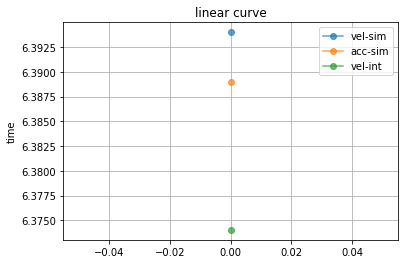

In [ ]:
for label, x in t_spent.items():
  plt.plot(x, marker='o', label=label, alpha=0.7)
plt.title('linear curve')
plt.grid(); plt.xlabel(''); plt.ylabel('time')
plt.legend();
plt.show()

### Exponential curves

$y = A \cdot e^{-B \cdot x} + C$

In [ ]:
Bs = (10 ** np.linspace(-1, 2, 16)) / pars['w']
Bs

array([0.001     , 0.00158489, 0.00251189, 0.00398107, 0.00630957,
       0.01      , 0.01584893, 0.02511886, 0.03981072, 0.06309573,
       0.1       , 0.15848932, 0.25118864, 0.39810717, 0.63095734,
       1.        ])

In [ ]:
t_spent = {mt: [] for mt in motion_types}
for B in Bs:
  # Generate objects
  curve_ = curve.CurveExp.generate_from_B(B, params_.h, params_.w)
    
  # vel-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
  t_spent['vel-sim'].append(t)

  # acc-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
  t_spent['acc-sim'].append(t)

  # integral-based
  t = motion_.cal_total_time_vel(None, curve_, 100000)
  t_spent['vel-int'].append(t)

In [ ]:
display(pd.DataFrame(t_spent, index=pd.Series(Bs, name='B')))

,vel-sim,acc-sim,vel-int
B,,,
0.001000,6.343,6.338,6.322747
0.001585,6.315,6.310,6.294522
0.002512,6.273,6.268,6.252361
0.003981,6.212,6.207,6.191690
0.006310,6.130,6.125,6.109782
0.010000,6.032,6.027,6.011174
0.015849,5.939,5.934,5.916727
0.025119,5.893,5.888,5.868707
0.039811,5.936,5.932,5.908974


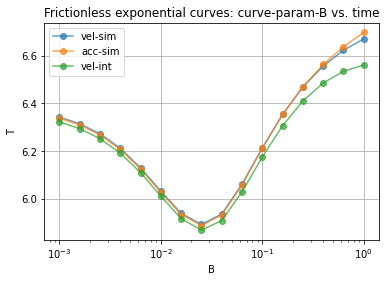

In [ ]:
for method, x in t_spent.items():
  plt.xscale('log')
  plt.plot(Bs, x, marker='o', alpha=0.7, label=method)
plt.title('Frictionless exponential curves: curve-param-B vs. time')
plt.legend(); plt.grid()
plt.xlabel('B'); plt.ylabel('T')
plt.savefig(f'{folder_output}timeSpent_ExpCurve.png')
plt.show()

### Parabolic curves

$y = A x^2 + B x + C$

In [ ]:
As = (10 ** np.linspace(-3, -1, 17))
As

array([0.001     , 0.00133352, 0.00177828, 0.00237137, 0.00316228,
       0.00421697, 0.00562341, 0.00749894, 0.01      , 0.01333521,
       0.01778279, 0.02371374, 0.03162278, 0.04216965, 0.05623413,
       0.07498942, 0.1       ])

In [ ]:
t_spent = {mt: [] for mt in motion_types}
for A in As:
  # Generate objects
  curve_ = curve.CurveParabola.generate_from_A(A, params_.h, params_.w)
    
  # vel-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
  t_spent['vel-sim'].append(t)

  # acc-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
  t_spent['acc-sim'].append(t)

  # integral-based
  t = motion_.cal_total_time_vel(None, curve_, 100000)
  t_spent['vel-int'].append(t)

In [ ]:
display(pd.DataFrame(t_spent, index=pd.Series(As, name='A')))

,vel-sim,acc-sim,vel-int
A,,,
0.001000,6.297,6.292,6.276981
0.001334,6.269,6.264,6.248460
0.001778,6.233,6.229,6.213108
0.002371,6.191,6.186,6.170370
0.003162,6.141,6.136,6.120482
0.004217,6.086,6.081,6.065170
0.005623,6.030,6.025,6.008779
0.007499,5.982,5.977,5.960137
0.010000,5.958,5.953,5.935791


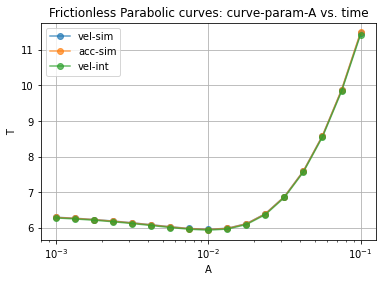

In [ ]:
for method, x in t_spent.items():
  plt.xscale('log')
  plt.plot(As, x, marker='o', alpha=0.7, label=method)
plt.title('Frictionless Parabolic curves: curve-param-A vs. time')
plt.legend(); plt.grid()
plt.xlabel('A'); plt.ylabel('T')
plt.savefig(f'{folder_output}timeSpent_ParabolicCurve.png')
plt.show()

## Compare curves & mk .gif animation

- Run with acc-sim base

In [ ]:
# Params
N_snapshots = 50

In [ ]:
curves = {
    'linear': curve.CurveLinear(params_.h, params_.w),
    'parabolic, a=1.00e-2': curve.CurveParabola.generate_from_A(1.00e-2, params_.h, params_.w),
    'exponential, b=2.51e-2': curve.CurveExp.generate_from_B(2.51e-2, params_.h, params_.w),
    'parabolic, a=2.00e-2': curve.CurveParabola.generate_from_A(2.00e-2, params_.h, params_.w),
    'exponential, b=1.00e-1': curve.CurveExp.generate_from_B(1.00e-1, params_.h, params_.w),
    'exponential, b=1.00e-0': curve.CurveExp.generate_from_B(1.00e-0, params_.h, params_.w),
}

In [ ]:
max_step = 0
rolling_history = {}
for name, curve_ in curves.items():
  _, hist = run_simulation(params_, motion_, curve_, motion_type='acc')
  rolling_history[name] = hist
  max_step = max(max_step, max(hist.keys()))

In [ ]:
step_snapshot = int(np.ceil(max_step // N_snapshots))
os.makedirs(f'{folder_output}snapshots/', exist_ok=True)

for step in range(0, max_step, step_snapshot):
  for name, hist in rolling_history.items():
    curve_ = curves[name]
    curve_.plot(label=f'{name}', alpha=0.7)

    if step in hist:
      t, x, y = hist[step]
    else:
      x, y = params_.w, 0
    
    plt.scatter(x, y)
  
  plt.title(f'Step={step}, Time={t:.3f}')
  plt.legend()
  plt.savefig(f'{folder_output}snapshots/{step:04d}.png')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with imageio.get_writer(
    f'{folder_output}/ball_rolling.gif', mode='I', duration=0.2,
  ) as writer:
  for step in range(0, max_step, step_snapshot):
    filename = f'{folder_output}snapshots/{step:04d}.png'
    image = imageio.imread(filename)
    writer.append_data(image)